## Import libraries

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Load area of interest

In [3]:
chosen_ageb = '0100100010515'

In [4]:
pop_schema = 'censoageb'
pop_table = 'censoageb_2020'
ent = '01'

query = f"SELECT * FROM {pop_schema}.{pop_table} WHERE \"cve_ent\" LIKE \'{ent}\'"
ags_pop_ageb = aup.gdf_from_query(query, geometry_col='geometry')
ags_pop_ageb = ags_pop_ageb.set_crs("EPSG:4326")

chosen_ageb_gdf = ags_pop_ageb.loc[ags_pop_ageb.cve_geo == chosen_ageb]

# Show
print(f"AGEB elegido con población de {chosen_ageb_gdf.pobtot.unique()}.")
chosen_ageb_gdf

AGEB elegido con población de [2585].


,cve_geo,cve_ent,cve_mun,cve_loc,cve_ageb,geometry,entidad,nom_ent,mun,nom_mun,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic,cve_geo_ageb
239,0100100010515,01,001,0001,0515,"POLYGON ((-102.29278 21.89010, -102.29275 21.8...",1,Aguascalientes,1,Aguascalientes,...,759.0,621.0,454.0,325.0,124.0,19.0,24.0,204.0,NaN,0100100010515


<Axes: >

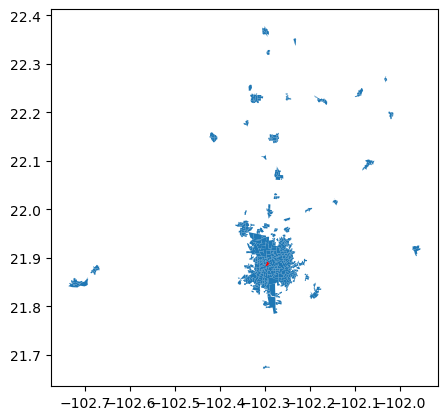

In [5]:
fig,ax = plt.subplots(figsize=(5,5))
chosen_ageb_gdf.plot(ax=ax,color='red',zorder=1)
ags_pop_ageb.plot(ax=ax,zorder=0)

## Methodology

### 1. Select nodes within AGEB

Created OSMnx graph from bounding polygon.
Converted OSMnx graph to 109 nodes and 194 edges GeoDataFrame.
Added column maxspeed for edges.
Added column bridge for edges.
Added column ref for edges.
Added column junction for edges.
Added column tunnel for edges.
Added column width for edges.
Added column service for edges.
Filtered columns.
Column: osmid in nodes gdf, has a list in it, the column data was converted to string.
Column: name in nodes gdf, has a list in it, the column data was converted to string.
Column: highway in nodes gdf, has a list in it, the column data was converted to string.


<Axes: >

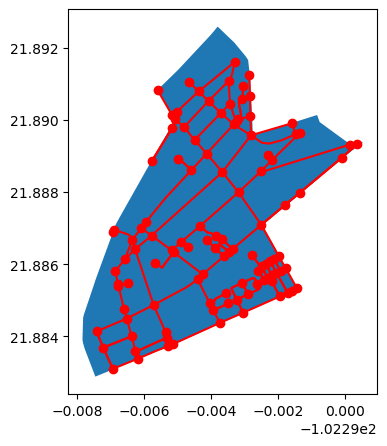

In [6]:
G, nodes, edges = aup.create_osmnx_network(chosen_ageb_gdf)

fig,ax = plt.subplots(figsize=(5,5))
nodes.plot(ax=ax,color='red',zorder=2)
edges.plot(ax=ax,zorder=1,color='red')
chosen_ageb_gdf.plot(ax=ax,zorder=0)

### 2. Polígonos de voronoi para los nodos

In [7]:
def voronoi_points_within_polygon (polygon,points,distance):
    # This function takes as input a polygon and points within that polygon
    # And returns the voronoi distribution of those points within that polygon
    # Distance is a number used to create a buffer around the polygon and coordinates along a bounding box of that buffer.
    
    # Set area of interest (polygon) and points of interest (nodes) for voronoi analysis to crs:6372
    aoi = polygon.to_crs("EPSG:6372")
    pois = points.to_crs("EPSG:6372")
    
    #Create a rectangular bound for the area of interest
    polygon = aoi['geometry'].unique()[0]
    bound = polygon.buffer(distance).envelope.boundary
    
    #Create points along the rectangular boundary
    boundarypoints = [bound.interpolate(distance=d) for d in range(0, np.ceil(bound.length).astype(int), distance)]
    boundarycoords = np.array([[p.x, p.y] for p in boundarypoints])
    
    #Load the points inside the polygon
    coords = np.array(pois.get_coordinates())
    
    #Create an array of all points on the boundary and inside the polygon
    all_coords = np.concatenate((boundarycoords, coords))
    
    # Calculate voronoi to all coords and create voronois gdf (No boundary)
    vor = Voronoi(points=all_coords)
    lines = [shapely.geometry.LineString(vor.vertices[line]) for line in 
        vor.ridge_vertices if -1 not in line]
    polys = shapely.ops.polygonize(lines)
    unbounded_voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), crs="epsg:6372")
    
    #Clip voronoi with boundary
    bounded_voronois = gpd.overlay(df1=unbounded_voronois, df2=aoi, how="intersection")
    
    # Change back crs
    voronois_gdf = bounded_voronois.to_crs("EPSG:4326")

    return voronois_gdf

In [8]:
# TEST USED TO UNDERSTAND WHAT'S GOING ON INSIDE FUNCTION

#bound_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bound), crs="epsg:6372")
#boundarypoints_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(boundarypoints), crs="epsg:6372")

# Show
#fig, ax = plt.subplots(figsize=(10, 10))
#poly_test.plot(ax=ax, edgecolor="red",facecolor='none', linewidth=6,zorder=0)
#bound_gdf.plot(ax=ax, color="maroon",linewidth=6,zorder=1)
#boundarypoints_gdf.plot(ax=ax, color="blue",zorder=2)
#unbounded_voronois.plot(ax=ax,edgecolor="yellow", linewidth=1,zorder=-1)

<Axes: >

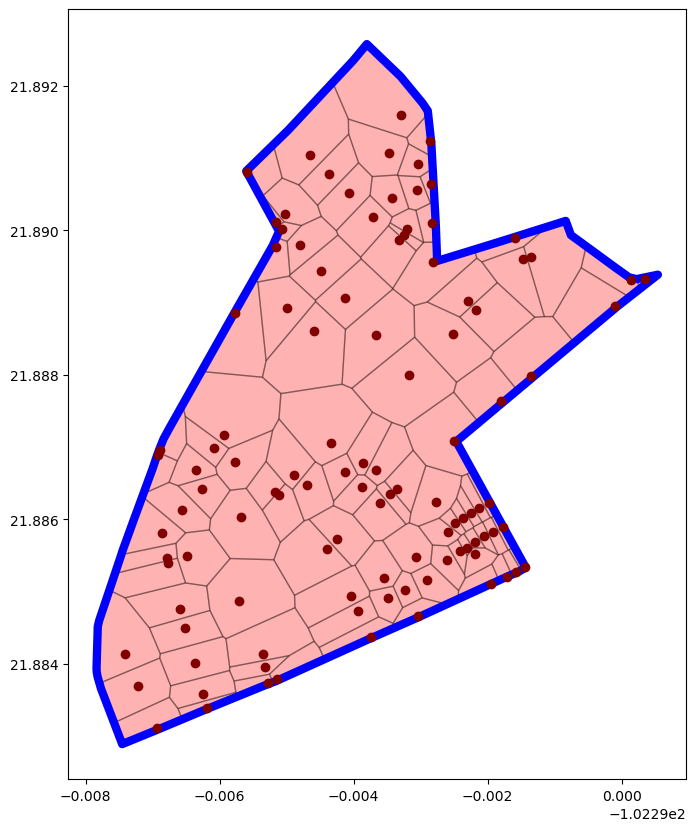

In [9]:
voronois_gdf = voronoi_points_within_polygon(chosen_ageb_gdf,nodes,100)

# Show
fig, ax = plt.subplots(figsize=(10, 10))
nodes.plot(ax=ax, color="maroon",zorder=2)
chosen_ageb_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=6,zorder=1)
voronois_gdf.plot(ax=ax, color="red", alpha=0.3, edgecolor="black",zorder=0)

In [10]:
# Add nodes osmid data to voronoi polygons
nodes_voronoi_gdf = gpd.sjoin(voronois_gdf,nodes[['osmid','geometry']])
nodes_voronoi_gdf = nodes_voronoi_gdf[['osmid','geometry']]

# Show
print(nodes_voronoi_gdf.shape)
nodes_voronoi_gdf.head(1)

(109, 2)


,osmid,geometry
0,842885080,"POLYGON ((-102.29507 21.89073, -102.29536 21.8..."


### 3. Intersección espacial con las manzanas y cálculo del área correspondiente a cada osmid

In [11]:
pop_schema = 'censo_mza'
pop_table = 'censo_mza_2020'
ent = '01'

query = f"SELECT * FROM {pop_schema}.{pop_table} WHERE \"CVE_ENT\" LIKE \'{ent}\'"
ags_pop_mza = aup.gdf_from_query(query, geometry_col='geometry')
ags_pop_mza = ags_pop_mza.set_crs("EPSG:4326")

mza_gdf = ags_pop_mza.loc[ags_pop_mza.CVE_AGEB == chosen_ageb[9:]]

# Show
print(mza_gdf.shape)
mza_gdf.head(1)

(48, 239)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
1972,0100100010515001,01,001,0001,0515,001,Urbana,Típica,"POLYGON ((-102.29552 21.88697, -102.29516 21.8...",1,...,35,49,41,27,18,3,None,None,14,0


<Axes: >

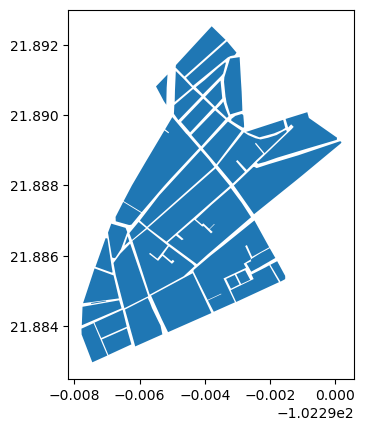

In [12]:
mza_gdf.plot()

In [13]:
# Calculate block area
mza_gdf = mza_gdf.to_crs("EPSG:6372")
mza_gdf['area_mza'] = mza_gdf.geometry.area
mza_gdf = mza_gdf.to_crs("EPSG:4326")

# Overlay blocks with voronoi
mza_voronoi = gpd.overlay(df1=mza_gdf, df2=nodes_voronoi_gdf, how="intersection")

# Calculate area distribution of block in voronoi zones
mza_voronoi = mza_voronoi.to_crs("EPSG:6372")
mza_voronoi['area_voronoi'] = mza_voronoi.geometry.area
mza_voronoi = mza_voronoi.to_crs("EPSG:4326")
mza_voronoi['area_pct'] = mza_voronoi['area_voronoi']/mza_voronoi['area_mza']

# Drop used columns
mza_voronoi.drop(columns=['area_mza','area_voronoi'],inplace=True)

# Show
print(mza_voronoi.shape)
mza_voronoi.head(1)

(281, 241)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,ENTIDAD,NOM_ENT,...,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,osmid,geometry,area_pct
0,0100100010515001,01,001,0001,0515,001,Urbana,Típica,1,Aguascalientes,...,27,18,3,None,None,14,0,7807788874,"POLYGON ((-102.29445 21.88785, -102.29416 21.8...",0.017779


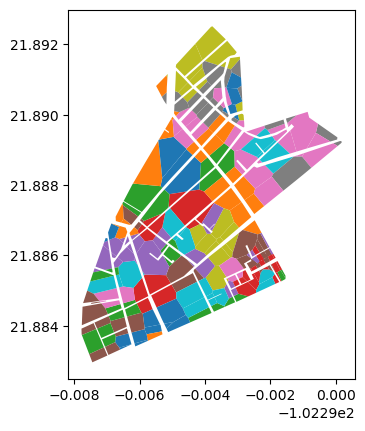

In [36]:
mza_voronoi_test = mza_voronoi.copy()
mza_voronoi_test['osmid'] = mza_voronoi_test['osmid'].astype(str)

mza_voronoi_test.plot('osmid')

del mza_voronoi_test

### 4. Suma de la población por nodo

In [38]:
list(mza_voronoi.columns)

['CVEGEO',
 'CVE_ENT',
 'CVE_MUN',
 'CVE_LOC',
 'CVE_AGEB',
 'CVE_MZA',
 'AMBITO',
 'TIPOMZA',
 'ENTIDAD',
 'NOM_ENT',
 'MUN',
 'NOM_MUN',
 'LOC',
 'NOM_LOC',
 'AGEB',
 'MZA',
 'POBTOT',
 'POBFEM',
 'POBMAS',
 'P_0A2',
 'P_0A2_F',
 'P_0A2_M',
 'P_3YMAS',
 'P_3YMAS_F',
 'P_3YMAS_M',
 'P_5YMAS',
 'P_5YMAS_F',
 'P_5YMAS_M',
 'P_12YMAS',
 'P_12YMAS_F',
 'P_12YMAS_M',
 'P_15YMAS',
 'P_15YMAS_F',
 'P_15YMAS_M',
 'P_18YMAS',
 'P_18YMAS_F',
 'P_18YMAS_M',
 'P_3A5',
 'P_3A5_F',
 'P_3A5_M',
 'P_6A11',
 'P_6A11_F',
 'P_6A11_M',
 'P_8A14',
 'P_8A14_F',
 'P_8A14_M',
 'P_12A14',
 'P_12A14_F',
 'P_12A14_M',
 'P_15A17',
 'P_15A17_F',
 'P_15A17_M',
 'P_18A24',
 'P_18A24_F',
 'P_18A24_M',
 'P_15A49_F',
 'P_60YMAS',
 'P_60YMAS_F',
 'P_60YMAS_M',
 'REL_H_M',
 'POB0_14',
 'POB15_64',
 'POB65_MAS',
 'PROM_HNV',
 'PNACENT',
 'PNACENT_F',
 'PNACENT_M',
 'PNACOE',
 'PNACOE_F',
 'PNACOE_M',
 'PRES2015',
 'PRES2015_F',
 'PRES2015_M',
 'PRESOE15',
 'PRESOE15_F',
 'PRESOE15_M',
 'P3YM_HLI',
 'P3YM_HLI_F',
 'P3YM_H

In [39]:
#cols = ['POBTOT','POBFEM','POBMAS',
#        'P_0A2','P_0A2_F','P_0A2_M',
#        'P_3A5','P_3A5_F','P_3A5_M',
#        'P_6A11','P_6A11_F','P_6A11_M',
#        'P_12A14','P_12A14_F','P_12A14_M',
#        'P_15A17','P_15A17_F','P_15A17_M',
#        'P_18A24','P_18A24_F','P_18A24_M',
#        'P_60YMAS','P_60YMAS_F','P_60YMAS_M']

cols = ['POBTOT']

nodes_gdf = nodes.copy()

for col in cols:
    # Turn column to numeric 
    mza_voronoi[col] = pd.to_numeric(mza_voronoi[col])

    # Calculate population proportional to voronoi area of block
    mza_voronoi[f'voronoi_{col}'] = mza_voronoi[col] * mza_voronoi['area_pct']
    
    # Group data by osmid
    col_data = mza_voronoi[['osmid',f'voronoi_{col}']]
    osmid_grouped_data = col_data.groupby('osmid').agg({f'voronoi_{col}':np.sum})
    
    # Merge data to nodes_gdf
    osmid_grouped_data.reset_index(inplace=True)
    nodes_gdf = pd.merge(nodes_gdf,osmid_grouped_data,on='osmid')
    nodes_gdf.rename(columns={f'voronoi_{col}':col},inplace=True)

print(nodes_gdf.shape)
nodes_gdf.head(1)

(107, 6)


,osmid,x,y,street_count,geometry,POBTOT
0,808115007,-102.296928,21.886893,3,POINT (-102.29693 21.88689),9.889239


### 5. Con base en la población que cayó en cada nodo, calcular un factor y multiplicar cada campo deseado del AGEB por ese factor

In [40]:
# Calculate factor (ageb_portion)
nodes_gdf['ageb_portion'] = nodes_gdf['POBTOT'] / chosen_ageb_gdf.pobtot.sum()

# Show
print(nodes_gdf.shape)
nodes_gdf.head(1)

(107, 7)


,osmid,x,y,street_count,geometry,POBTOT,ageb_portion
0,808115007,-102.296928,21.886893,3,POINT (-102.29693 21.88689),9.889239,0.003826


In [41]:
cols = ['POBFEM','POBMAS',
        'P_0A2','P_0A2_F','P_0A2_M',
        'P_3A5','P_3A5_F','P_3A5_M',
        'P_6A11','P_6A11_F','P_6A11_M',
        'P_12A14','P_12A14_F','P_12A14_M',
        'P_15A17','P_15A17_F','P_15A17_M',
        'P_18A24','P_18A24_F','P_18A24_M',
        'P_60YMAS','P_60YMAS_F','P_60YMAS_M']

for col in cols:
    nodes_gdf[col] = chosen_ageb_gdf[col.lower()].sum() * nodes_gdf['ageb_portion']
    print(f'Calculated AGEB {col} to nodes.')

nodes_gdf.drop(columns=['ageb_portion'],inplace=True)

# Show
print(nodes_gdf.shape)
nodes_gdf.head(1)

Calculated AGEB POBFEM to nodes.
Calculated AGEB POBMAS to nodes.
Calculated AGEB P_0A2 to nodes.
Calculated AGEB P_0A2_F to nodes.
Calculated AGEB P_0A2_M to nodes.
Calculated AGEB P_3A5 to nodes.
Calculated AGEB P_3A5_F to nodes.
Calculated AGEB P_3A5_M to nodes.
Calculated AGEB P_6A11 to nodes.
Calculated AGEB P_6A11_F to nodes.
Calculated AGEB P_6A11_M to nodes.
Calculated AGEB P_12A14 to nodes.
Calculated AGEB P_12A14_F to nodes.
Calculated AGEB P_12A14_M to nodes.
Calculated AGEB P_15A17 to nodes.
Calculated AGEB P_15A17_F to nodes.
Calculated AGEB P_15A17_M to nodes.
Calculated AGEB P_18A24 to nodes.
Calculated AGEB P_18A24_F to nodes.
Calculated AGEB P_18A24_M to nodes.
Calculated AGEB P_60YMAS to nodes.
Calculated AGEB P_60YMAS_F to nodes.
Calculated AGEB P_60YMAS_M to nodes.
(107, 29)


,osmid,x,y,street_count,geometry,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,...,P_12A14_M,P_15A17,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_60YMAS,P_60YMAS_F,P_60YMAS_M
0,808115007,-102.296928,21.886893,3,POINT (-102.29693 21.88689),9.889239,5.267885,4.621354,0.271619,0.141548,...,0.206584,0.30605,0.137722,0.168327,1.036744,0.554716,0.482029,2.356585,1.465214,0.891371


In [42]:
test_df = pd.DataFrame()

i = 0
for col in (['POBTOT']+cols):
    # Turn column to numeric 
    mza_gdf[col] = pd.to_numeric(mza_gdf[col])
    chosen_ageb_gdf[col.lower()] = pd.to_numeric(chosen_ageb_gdf[col.lower()]) #chosen_ageb_gdf is censo_ageb_2020 for this ageb

    ageb_value = chosen_ageb_gdf[col.lower()].sum() 
    blocks_value = mza_gdf[col].sum()
    nodes_value = nodes_gdf[col].sum()

    test_df.loc[i,'atr'] = col
    test_df.loc[i,'blocks'] = blocks_value
    test_df.loc[i,'nodes'] = nodes_value
    test_df.loc[i,'ageb'] = ageb_value

    i = i+1

test_df['diff'] = test_df['nodes'] - test_df['ageb']
test_df['blocks_diff'] = test_df['blocks'] - test_df['ageb']
test_df = test_df[['atr','ageb','nodes','diff','blocks','blocks_diff']]

test_df

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,atr,ageb,nodes,diff,blocks,blocks_diff
0,POBTOT,2585.0,2584.941053,-0.058947,2585.0,0.0
1,POBFEM,1377.0,1376.968599,-0.031401,1369.0,-8.0
2,POBMAS,1208.0,1207.972453,-0.027547,1200.0,-8.0
3,P_0A2,71.0,70.998381,-0.001619,56.0,-15.0
4,P_0A2_F,37.0,36.999156,-0.000844,21.0,-16.0
5,P_0A2_M,34.0,33.999225,-0.000775,17.0,-17.0
6,P_3A5,80.0,79.998176,-0.001824,53.0,-27.0
7,P_3A5_F,31.0,30.999293,-0.000707,15.0,-16.0
8,P_3A5_M,49.0,48.998883,-0.001117,26.0,-23.0
9,P_6A11,153.0,152.996511,-0.003489,134.0,-19.0


## Conclusion

Methodology works as predicted. Pop data is successfuly transfered from ageb to nodes using nodes-voronoi_blocks's population as a distribution method.

However, given the differences between block data and ageb data, we should not use block data as a baseline.

Work in Progess on a method to fix block data (Notebook experimental-blockdata-inegi-fix) will be used to have a reliable baseline.

## All cities integration (later, once methodology is confirmed)

In [2]:
# gdf_mun
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'

query = f"SELECT * FROM {metro_schema}.{metro_table}"
metro_gdf = aup.gdf_from_query(query, geometry_col='geometry')
metro_gdf = metro_gdf.set_crs("EPSG:4326")

city_list = list(metro_gdf.city.unique())

# Show
print(metro_gdf.shape)
print(len(city_list))
print(city_list)
metro_gdf.head(1)

(367, 6)
71
['Aguascalientes', 'Ensenada', 'Mexicali', 'Tijuana', 'La Paz', 'Los Cabos', 'Campeche', 'Laguna', 'Monclova', 'Piedras Negras', 'Saltillo', 'Colima', 'Tapachula', 'Tuxtla', 'Chihuahua', 'Delicias', 'Juarez', 'CDMX', 'ZMVM', 'Durango', 'Celaya', 'Guanajuato', 'Leon', 'Irapuato', 'Acapulco', 'Chilpancingo', 'Pachuca', 'Tulancingo', 'Guadalajara', 'Vallarta', 'Piedad', 'Toluca', 'Morelia', 'Zamora', 'Uruapan', 'Cuautla', 'Cuernavaca', 'Tepic', 'Monterrey', 'Oaxaca', 'Puebla', 'San Martin', 'Tehuacan', 'Queretaro', 'Cancun', 'Chetumal', 'Playa', 'SLP', 'Culiacan', 'Los Mochis', 'Mazatlan', 'Guaymas', 'Ciudad Obregon', 'Hermosillo', 'Nogales', 'Villahermosa', 'Victoria', 'Matamoros', 'Nuevo Laredo', 'Reynosa', 'Tampico', 'Tlaxcala', 'Coatzacoalcos', 'Cordoba', 'Minatitlan', 'Orizaba', 'Poza Rica', 'Veracruz', 'Xalapa', 'Merida', 'Zacatecas']


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",Aguascalientes


In [19]:
censo_column_start = 14 #column where numeric data starts in censo (16 for 2010, 14 for 2020)
censo_column_end = 0 #column where numeric data ends in censo (-1 for 2010, all up to the end (0) for 2020)
year = '2020'
pop_schema = 'censoageb'
pop_table = 'censoageb_' + year

res_list = [8] #Only 8,9,10 and 11 available

save_schema = 'censo'
save_table = f'censo_inegi_{year[:2]}_ageb_hex'

In [43]:
def main():
    # Load city
    city_gdf = metro_gdf.loc[metro_gdf.city == city]

    # Load agebs of city
    ageb_gdf = gpd.GeoDataFrame()
    for cvegeo in list(city_gdf.CVEGEO.unique()):
        query = f"SELECT * FROM {pop_schema}.{pop_table} WHERE \"cve_geo\" LIKE \'{cvegeo}%%\'"
        ageb_gdf = pd.concat([ageb_gdf,aup.gdf_from_query(query, geometry_col='geometry')])

    # Load hexgrids of city
    hex_bins = gpd.GeoDataFrame()
    for res in res_list:
        # Load hexgrids
        query = f"SELECT * FROM hexgrid.hexgrid_{res}_city_2020 WHERE \"city\" LIKE \'{city}\'"
        hex_bins = pd.concat([hex_bins,aup.gdf_from_query(query, geometry_col='geometry')])    
    hex_bins = hex_bins.set_crs("EPSG:4326")

    return (ageb_gdf,hex_bins)

In [44]:
k = len(city_list)

# prevent cities being analyzed several times in case of a crash
processed_city_list = []
try:
    query = f"SELECT city FROM {save_schema}.{save_table}"
    cities_processed = aup.df_from_query(query)
    processed_city_list = list(cities_processed.city.unique())
except:
    pass

# PRINT PROGRESS
missing_cities_list = []
for city in city_list:
    if city not in processed_city_list:
        missing_cities_list.append(city)

i = len(processed_city_list)
print(f'Already processed ({i}/{k}) cities.')
print(f'Missing procesing for cities: {missing_cities_list}')
 
# SKIP FAILED CITIES
skip_city_list = []

missing_cities_list = ['Aguascalientes']

for city in missing_cities_list:
    if city not in skip_city_list:
        print("--"*40)
        i = i + 1
        print(f"Starting city {i}/{k}: {city}")
        ageb_gdf,hex_bins = main()
        #main(schema, folder_sufix, year, censo_column_start, censo_column_end, save=True)

Already processed (0/71) cities.
Missing procesing for cities: ['Aguascalientes', 'Ensenada', 'Mexicali', 'Tijuana', 'La Paz', 'Los Cabos', 'Campeche', 'Laguna', 'Monclova', 'Piedras Negras', 'Saltillo', 'Colima', 'Tapachula', 'Tuxtla', 'Chihuahua', 'Delicias', 'Juarez', 'CDMX', 'ZMVM', 'Durango', 'Celaya', 'Guanajuato', 'Leon', 'Irapuato', 'Acapulco', 'Chilpancingo', 'Pachuca', 'Tulancingo', 'Guadalajara', 'Vallarta', 'Piedad', 'Toluca', 'Morelia', 'Zamora', 'Uruapan', 'Cuautla', 'Cuernavaca', 'Tepic', 'Monterrey', 'Oaxaca', 'Puebla', 'San Martin', 'Tehuacan', 'Queretaro', 'Cancun', 'Chetumal', 'Playa', 'SLP', 'Culiacan', 'Los Mochis', 'Mazatlan', 'Guaymas', 'Ciudad Obregon', 'Hermosillo', 'Nogales', 'Villahermosa', 'Victoria', 'Matamoros', 'Nuevo Laredo', 'Reynosa', 'Tampico', 'Tlaxcala', 'Coatzacoalcos', 'Cordoba', 'Minatitlan', 'Orizaba', 'Poza Rica', 'Veracruz', 'Xalapa', 'Merida', 'Zacatecas']
--------------------------------------------------------------------------------
Starti

In [42]:
ageb_gdf.nom_mun.unique()

array(['Aguascalientes', 'Jesús María', 'San Francisco de los Romo'],
      dtype=object)

In [7]:
# city
#metro_schema = 'metropolis'
#metro_table = 'metro_gdf_2020'
#c = 'Aguascalientes'

#query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{c}\'"
#metro_gdf = aup.gdf_from_query(query, geometry_col='geometry')
#metro_gdf = metro_gdf.set_crs("EPSG:4326")
#aoi = metro_gdf.dissolve()

# Show
#print(metro_gdf.shape)
#metro_gdf.head(1)

In [8]:
# agebs_gdf
#agebs_schema = 'marco'
#agebs_table = 'ageb_2020'

#agebs_gdf = aup.gdf_from_polygon(aoi,agebs_schema,agebs_table)

# Show
#print(agebs_gdf.shape)
#agebs_gdf.head(1)